In [1]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from typing import Callable, Optional, List, Tuple, Dict

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal
from chirho.indexed.handlers import IndexPlatesMessenger
from chirho.observational.handlers.soft_conditioning import IndexCutModule, cut
from pyro.infer import Predictive

sns.set_style("white")

pyro.set_rng_seed(321) # for reproducibility

In [2]:
class VanillaLinearCATE(pyro.nn.PyroModule):
    def __init__(self, p: int):
        super().__init__()
        self.p = p
    
    def forward():
        intercept = pyro.sample("intercept", dist.Normal(0., 1.))
        weights = pyro.sample("theta", dist.Normal(0., 1.).expand((self.p, )).to_event(1))
        tau = pyro.sample("tau", dist.Normal(0., 1.))
        return lambda x, a: intercept + x @ weights + a * tau

In [84]:
class AbstractDRLearner(pyro.nn.PyroModule):
    """
    AbstractDRLearner is a base class for all DR learners. It is based on the following paper:
    https://arxiv.org/abs/2004.14497.
    """
    def __init__(
            self, p: int, outcome_noise_scale: float = 1., pseudo_noise_scale: float = 1.
        ):
        super().__init__()
        self.p = p
        self.outcome_noise_scale = outcome_noise_scale
        self.pseudo_noise_scale = pseudo_noise_scale
    
    def _get_module_param(self, param, module_ix):
        if len(param.shape) > 1:
            return param[module_ix].squeeze()
        return param
    
    def sample_propensity_model(self) -> Callable:
        raise NotImplementedError

    def sample_outcome_model(self) -> Callable:
        raise NotImplementedError

    def sample_cate(self) -> Callable:
        raise NotImplementedError
    
    def pseudo_outcome(
        self, D: Dict, propensity_model: Callable, outcome_model: Callable, module_ix: int
    ) -> torch.Tensor:
        X, A, Y = D["X"], D["A"], D["Y"]
        N = X.shape[0]
        propensity_scores = propensity_model(X, module_ix)
        probs = torch.special.expit(propensity_scores)
        outcome_0 = outcome_model(X, torch.zeros(N), module_ix)
        outcome_1 = outcome_model(X, torch.ones(N), module_ix)
        outcome_A = outcome_model(X, A, module_ix)
        traditional_term = outcome_1 - outcome_0  # vanilla cate estimate
        correction_term = (Y - outcome_A) * (A - probs) / (probs * (1 - probs))  # double robustness correction
        return traditional_term + correction_term
    
    def forward(self, D1: Dict, D2: Dict, **kwargs):
        propensity_score = self.sample_propensity_model(**kwargs)
        outcome_model = self.sample_outcome_model(**kwargs)
        cate_model = self.sample_cate(**kwargs)

        # Treatment conditioning
        X1, A1, Y1 = D1['X'], D1['A'], D1['Y']
        with pyro.plate("treatment", X1.shape[0]):
            pyro.sample("A", dist.Bernoulli(logits=propensity_score(X1, 0)), obs=A1)
    
        # Outcome conditioning
        with pyro.plate("outcome", X1.shape[0]):
            pyro.sample("Y", dist.Normal(outcome_model(X1, A1, 0), self.outcome_noise_scale), obs=Y1)
        
        # pseudo outcome conditioning
        X2 = D2['X']
        Y_pseudo = self.pseudo_outcome(D2, propensity_score, outcome_model, 1)
        with pyro.plate("pseudo_outcome", X2.shape[0]):
            # Hack to get correct conditional dependence structure rendered
            # pyro.sample("Y_pseudo_residuals", dist.Normal(Y_pseudo - cate_model(X2, 1), self.pseudo_noise_scale), obs=torch.zeros(X2.shape[0]))
            pyro.sample("Y_pseudo_residuals", dist.Normal(cate_model(X2, 1), self.pseudo_noise_scale), obs=Y_pseudo)


class LinearDRLearner(AbstractDRLearner):
    def sample_propensity_model(self) -> Callable:
        intercept = pyro.sample("propensity_intercept", dist.Normal(0., 1./math.sqrt(self.p)))
        weights = pyro.sample("propensity_weights", dist.Normal(0., 1./math.sqrt(self.p)).expand((self.p, )).to_event(1))
        return lambda x, module_ix: self._get_module_param(intercept, module_ix) + x @ self._get_module_param(weights, module_ix)

    def sample_outcome_model(self) -> Callable:
        intercept = pyro.sample("outcome_intercept", dist.Normal(0., 1.))
        weights = pyro.sample("outcome_weights", dist.Normal(0., 1.).expand((self.p, )).to_event(1))
        tau = pyro.sample("treatment_weight", dist.Normal(0., 1.))
        return lambda x, a, module_ix: self._get_module_param(intercept, module_ix) + x @ self._get_module_param(weights, module_ix) + a * self._get_module_param(tau, module_ix)

    def sample_cate(self) -> Callable:
        intercept = pyro.sample("cate_intercept", dist.Normal(0., 1.))
        weights = pyro.sample("cate_weights", dist.Normal(0., 1.).expand((self.p, )).to_event(1))
        return lambda x, module_ix: self._get_module_param(intercept, module_ix) + x @ self._get_module_param(weights, module_ix)

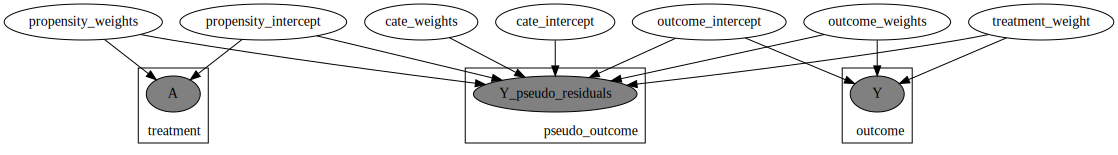

In [5]:
# Made up data for testing
D1 = {
    "X": torch.tensor([[1., 0., 3.], [0., 1., -1.], [1., 1., 4.]]),
    "A": torch.tensor([1., 0., 1.]),
    "Y": torch.tensor([4., 2., -1.])
}

D2 = {
    "X": torch.tensor([[.5, .2, -3.], [3., 2., 1.], [0.6, 1., -1.]]),
    "A": torch.tensor([0., 1., 1.]),
    "Y": torch.tensor([2., -1, 2.])
}

model = LinearDRLearner(3)
pyro.render_model(model, model_args=(D1, D2))

In [11]:
module_one_vars = [
    "propensity_intercept", "propensity_weights", 
    "outcome_intercept", "outcome_weights", 
    "treatment_weight", "A", "Y"
]

def run_svi_inference(
    model: Callable, vi_family: Optional[Callable] = None, guide: Optional[Callable] = None, n_steps=100, verbose=True, **model_kwargs
):
    if guide is None:
        guide = vi_family(model)
    adam = pyro.optim.Adam({"lr": 0.03})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    # Do gradient steps
    pyro.clear_param_store()
    for step in range(1, n_steps + 1):
        loss = svi.step(**model_kwargs)
        if (step % 1000 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))

    return guide

def make_cut_model_single(p, module_one_vars):
    model =  LinearDRLearner(p)
    def cut_model_single(*args, **kwargs):
        with IndexPlatesMessenger(), IndexCutModule(module_one_vars):
            model(*args, **kwargs)
    return cut_model_single

p = 3
cut_model_single = make_cut_model_single(p, module_one_vars)
cut_guide_single = run_svi_inference(cut_model_single, vi_family=AutoNormal, n_steps=1, D1=D1, D2=D2)
cut_samples_single = Predictive(cut_model_single, guide=cut_guide_single, num_samples=1)(D1=D1, D2=D2)

[iteration 0001] loss: 70.8813


In [86]:
# Generate data as in Figure 4b but use Gaussian responses instead of Bernoulli
class HighDimLinearModel(pyro.nn.PyroModule):
    def __init__(self, p: int):
        super().__init__()
        self.p = p
    
    def sample_propensity_weights(self):
        return pyro.sample("propensity_weights", dist.Normal(0., 1./math.sqrt(self.p)).expand((self.p, )).to_event(1))
    
    def sample_outcome_weights(self):
        return pyro.sample("outcome_weights", dist.Normal(0.,  1./math.sqrt(self.p)).expand((self.p, )).to_event(1))

    def forward(self, X: torch.Tensor):
        N = X.shape[0]
        propensity_weights = self.sample_propensity_weights()
        outcome_weights = self.sample_outcome_weights()
        with pyro.plate("obs", N):
            A = pyro.sample("A", dist.Bernoulli(logits=X @ propensity_weights))
            Y = pyro.sample("Y", dist.Normal(X @ outcome_weights, 1.))
        

class BenchmarkLinearModel(HighDimLinearModel):
    def __init__(self, p: int, alpha: int, beta: int):
        super().__init__(p)
        self.alpha = alpha # sparsity of propensity weights
        self.beta = beta # sparisty of outcome weights

    def sample_propensity_weights(self):
        propensity_weights = 1 / math.sqrt(4 * self.alpha) * torch.ones(self.p)
        propensity_weights[self.alpha:] = 0.
        return propensity_weights
    
    def sample_outcome_weights(self):
        outcome_weights = 1 / math.sqrt(4 * self.beta) * torch.ones(self.p)
        outcome_weights[self.beta:] = 0.
        return outcome_weights


In [54]:
p = 500
alpha = 10
beta = 10
N_train = 1000
N_test = 500
benchmark_model = BenchmarkLinearModel(p, alpha, beta)
X_train = dist.Normal(0., 1.).expand((N_train, p)).to_event(1).sample()
X_test = dist.Normal(0., 1.).expand((N_test, p)).to_event(1).sample()

with pyro.poutine.trace() as training_data:
    benchmark_model(X_train)

with pyro.poutine.trace() as testing_data:
    benchmark_model(X_test)

A_train = training_data.trace.nodes["A"]["value"]
Y_train = training_data.trace.nodes["Y"]["value"]
D_train = {"X": X_train, "A": A_train, "Y": Y_train}

A_test = testing_data.trace.nodes["A"]["value"]
Y_test = testing_data.trace.nodes["Y"]["value"]
D_test = {"X": X_test, "A": A_test, "Y": Y_test}

In [87]:
plug_in_model = HighDimLinearModel(p)
plug_in_model_conditioned = pyro.poutine.condition(plug_in_model, data=D_train)
plug_in_guide = run_svi_inference(plug_in_model_conditioned, vi_family=AutoNormal, n_steps=5000, X=X_train)
plug_in_samples_test = Predictive(plug_in_model_conditioned, guide=plug_in_guide, num_samples=1000)(X=X_test)

[iteration 0001] loss: 6780.2487
[iteration 1000] loss: 2511.0466
[iteration 2000] loss: 2497.8009
[iteration 3000] loss: 2442.7480
[iteration 4000] loss: 2543.6138
[iteration 5000] loss: 2546.7113


In [85]:
D1 = {"X": X_train[:N_train//2], "A": A_train[:N_train//2], "Y": Y_train[:N_train//2]}
D2 = {"X": X_train[N_train//2:], "A": A_train[N_train//2:], "Y": Y_train[N_train//2:]}

cut_model_single = make_cut_model_single(p, module_one_vars)
cut_guide_single = run_svi_inference(cut_model_single, vi_family=AutoNormal, n_steps=5000, D1=D1, D2=D2)
cut_samples_single = Predictive(cut_model_single, guide=cut_guide_single, num_samples=1000)(D1=D1, D2=D2)

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'__index_plate_____cut_plate'}
  warnings.warn(


[iteration 0001] loss: 1438531.0016
[iteration 1000] loss: 16667.6311
[iteration 2000] loss: 81659.1838
[iteration 3000] loss: 23661.5204
[iteration 4000] loss: 15388.4630
[iteration 5000] loss: 22804.4260


In [92]:
(cut_guide_single.median()['cate_weights'][1] ** 2).sum()

tensor(704.3757)